In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.17
    Uninstalling fastai-2.7.17:
      Successfully uninstalled fastai-2.7.17


In [4]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [5]:
urls = search_images('healthy rice leaf', max_images=1)
urls[0]

'https://www.healthbenefitstimes.com/9/gallery/african-rice/Leaves-of-African-rice.jpg'

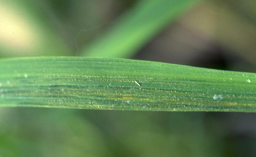

In [6]:
from fastdownload import download_url
dest = 'healthy_leaf.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

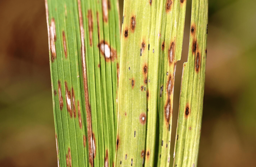

In [8]:
download_url(search_images('rice paddy leaf diseases', max_images=1)[0], 'paddy_disease.jpg', show_progress=False)
Image.open('paddy_disease.jpg').to_thumb(256,256)

In [9]:
searches = 'healthy rice leaf', 'rice bacterial leaf blight symptoms', 'rice blast disease leaf', 'rice brown spot disease', 'rice paddy leaf diseases'
path = Path('Rice')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

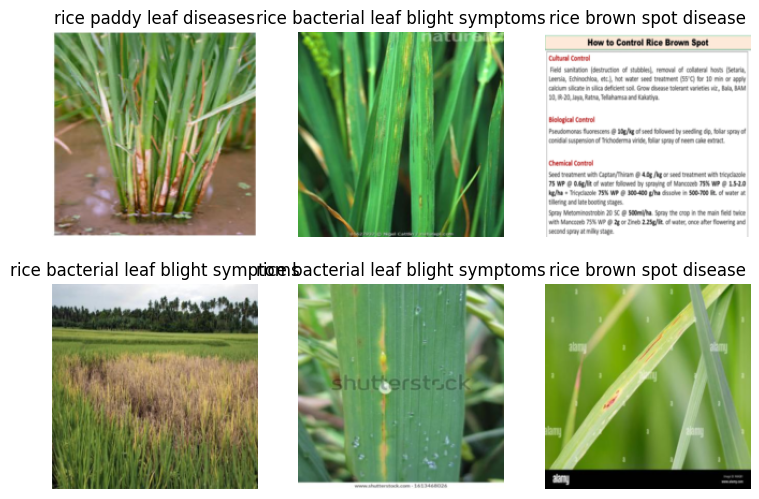

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.762815,2.022414,0.684615,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.939564,1.940975,0.707692,00:02
1,1.639275,2.418633,0.669231,00:02
2,1.336379,2.545426,0.692308,00:02
3,1.159133,2.492845,0.669231,00:02
4,0.946536,2.492130,0.661538,00:02


In [26]:
is_healthy,_,probs = learn.predict(PILImage.create('brown.jpg'))
print(f"This is a: {is_healthy}.")
# print(f"Probability it's a healthy leaf: {probs[0]:.4f}")
print(probs)

This is a: rice brown spot disease.
tensor([0.0021, 0.0101, 0.0294, 0.8827, 0.0757])


In [ ]:
learn.export('rice.pkl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
dest = 'brown.jpg'
download_url('https://www.agric.wa.gov.au/sites/gateway/files/leafblast.jpg', dest, show_progress=True)